In [29]:
from scipy.io import loadmat
from scipy.linalg import eigh, inv
import numpy as np
import matplotlib.pyplot as plt

## Load graph dataset

In [30]:
# load gene network
gene_network = loadmat('data/genetics/geneNetwork_rawPCNCI.mat')
A = gene_network['geneNetwork_rawPCNCI'].astype(np.int32)

# load signal dataset 
signals = loadmat('data/genetics/signal_mutation.mat')
X = signals['signal_mutation'].T.astype(np.float32)

# load phenotypes (labels)
phenotypes = loadmat('data/genetics/histology_subtype.mat')
y = phenotypes['histology_subtype']

'Shapes: A: {}, X: {}, y: {}'.format(A.shape, X.shape, y.shape)

'Shapes: A: (2458, 2458), X: (2458, 240), y: (240, 1)'

## a) Distinguishing power

In [59]:
# Compute Laplacian as shift matrix
D = np.diag(A.sum(axis=1))
L = D - A
S = L

# Diagonalize S (reorder evals from largest to smallest)
w, V = eigh(S)
W = np.diag(w)

# verify diagonalization (should be near 0, due to float errors)
print('L1 norm between L and V @ W @ V.T: {}'.format((L - np.dot(np.dot(V, W), V.T)).sum()))

L1 norm between L and V @ W @ V.T: 1.305906509562601e-11


In [60]:
X_gft = V.T @ X # x_gft[i, j] is coefficient of ith freq for jth sample

# verify GFT is valid (should be near 0)
print('Error after V @ V.T @ X: {}'.format(np.linalg.norm(X - (V @ X_gft))))

Error after V @ V.T @ X: 2.510261873768074e-13


In [61]:
# label masks
mask_1 = (y == 1).astype(int).reshape(y.shape[0])
mask_2 = (y == 2).astype(int).reshape(y.shape[0])

# mean filter for each label
mean_1 = mask_1 / mask_1.sum()
mean_2 = mask_2 / mask_2.sum()

# L1 norm of each frequency
k_L1 = np.linalg.norm(X_gft, ord=1, axis=1)

In [62]:
DP = np.absolute((X_gft @ mean_1) - (X_gft @ mean_2)) / k_L1
DP = DP.reshape(DP.shape[0])

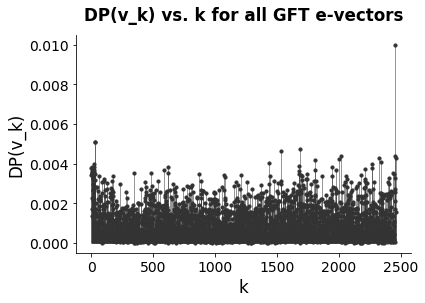

In [63]:
plt.scatter(range(DP.shape[0]), DP, s=10)
plt.vlines(range(DP.shape[0]), 0, DP, linestyle="solid", linewidths=0.5)
plt.xlabel('k')
plt.ylabel('DP(v_k)')
plt.title('DP(v_k) vs. k for all GFT e-vectors');

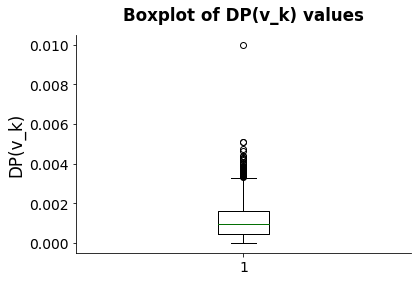

In [64]:
plt.boxplot(DP)
plt.title('Boxplot of DP(v_k) values')
plt.ylabel('DP(v_k)');

## b) kNN classifier

In [65]:
def knn(X, y, k_all):
    """
    Computes kNN accuracy using leave-one-out cross-validation, 
        for several values of k  
    """
    # compute pairwise Euclidean distances between all samples
    dists_all = np.full((X.shape[1], X.shape[1]), np.inf)
    for i in range(X.shape[1]):
        for j in range(i+1, X.shape[1]):
            if i == j:
                continue
            dist = np.sqrt(((X[:, i] - X[:, j]) ** 2).sum())
            dists_all[i, j] = dist
            dists_all[j, i] = dist

    # get nearest neighbors of each sample
    nns = np.argsort(dists_all, axis=1)

    # compute cross-val accuracy
    for k in k_all:
        correct = 0
        for col in range(len(X[0])):
            knns = nns[col, :k]
            pred = ((y[knns, 0]).mean() > 1.5) + 1

            correct += pred == y[col, 0]

        print('\tAccuracy using k = {0}: {1:.4f}'.format(k, correct / X.shape[1]))

In [66]:
print('Using all frequencies:')
knn(X, y, [3, 5, 7])

Using all frequencies:
	Accuracy using k = 3: 0.8833
	Accuracy using k = 5: 0.8833
	Accuracy using k = 7: 0.8542


## c) Filtering almost all frequencies

In [67]:
def filter_gft(X_gft, k_idxs, keep_ratio):
    """
    Filters the GFT of a signal matrix to preserve only the top keep_ratio frequencies,
        as ordered by k_idxs
    
    X_gft: the GFT of signal matrix X
    k_idxs: priority order with which to keep frequencies
    keep_ratio: ratio of frequency coefficients to preserve in the signal GFT

    Returns X_gft, but with coefficients for frequencies outside the top keep_ratio set to 0
    """
    # select frequencies to keep
    n_keep = int(len(k_idxs) * keep_ratio)
    k_top = k_idxs[:n_keep]
    print('\tKept {} frequencies'.format(n_keep))
    
    # set all other frequency coefficients to 0
    X_gft_f = np.zeros(X_gft.shape)
    X_gft_f[k_top, :] = X_gft[k_top, :]

    return X_gft_f

In [68]:
def filtered_knn(X_gft, y, k_idxs, keep_ratio, n_nbrs_all):
    """
    Filters the GFT of a signal matrix, then evaluates classification accuracy using kNN

    X_gft: the GFT of signal matrix X
    y: labels vector
    k_idxs: priority order with which to keep frequencies
    keep_ratio: ratio of frequency coefficients to preserve in the signal GFT
    n_nbrs_all: the different values of k to try for kNN
    """

    # preserve only values at the top frequency
    X_gft_f = filter_gft(X_gft, k_idxs, keep_ratio)
    
    # take iGFT of filtered signal
    X_f = V @ X_gft_f
    
    # kNN
    knn(X_f, y, n_nbrs_all)

In [69]:
# order frequencies by DP
k_idxs = np.argsort(DP)[::-1]
print('k = {} maximizes distinguishing power'.format(k_idxs[0]))

# try kNN, keeping only the top frequency
filtered_knn(X_gft, y, k_idxs, 1 / len(k_idxs), [3, 5, 7])

k = 2455 maximizes distinguishing power
	Kept 1 frequencies
	Accuracy using k = 3: 0.9000
	Accuracy using k = 5: 0.8875
	Accuracy using k = 7: 0.8917


In [70]:
# try kNN, with other values of p
p_all = [0.75, 0.8, 0.85, 0.9, 0.95]

for p in p_all[::-1]:
    print('With top {} of frequencies (p = {}):'.format(np.round(1 - p, decimals=2), p))
    filtered_knn(X_gft, y, k_idxs, 1 - p, [3, 5, 7])

With top 0.05 of frequencies (p = 0.95):
	Kept 122 frequencies
	Accuracy using k = 3: 0.9167
	Accuracy using k = 5: 0.9167
	Accuracy using k = 7: 0.9167
With top 0.1 of frequencies (p = 0.9):
	Kept 245 frequencies
	Accuracy using k = 3: 0.9167
	Accuracy using k = 5: 0.9250
	Accuracy using k = 7: 0.9250
With top 0.15 of frequencies (p = 0.85):
	Kept 368 frequencies
	Accuracy using k = 3: 0.9125
	Accuracy using k = 5: 0.9125
	Accuracy using k = 7: 0.9208
With top 0.2 of frequencies (p = 0.8):
	Kept 491 frequencies
	Accuracy using k = 3: 0.9208
	Accuracy using k = 5: 0.9167
	Accuracy using k = 7: 0.9167
With top 0.25 of frequencies (p = 0.75):
	Kept 614 frequencies
	Accuracy using k = 3: 0.9125
	Accuracy using k = 5: 0.9167
	Accuracy using k = 7: 0.9167
